In [146]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import skfuzzy as fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from skfuzzy import control as ctrl
import random

In [147]:
PATH = './AMAZON_FASHION.json.gz'
PATH_meta = './meta_AMAZON_FASHION.json.gz'

## MODULO 1
### Lector de datasets

In [148]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [149]:
df = getDF(PATH)
df_meta = getDF(PATH_meta)

In [150]:
df_meta.shape

(186637, 16)

In [151]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [152]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

Text(0, 0.5, 'Count')

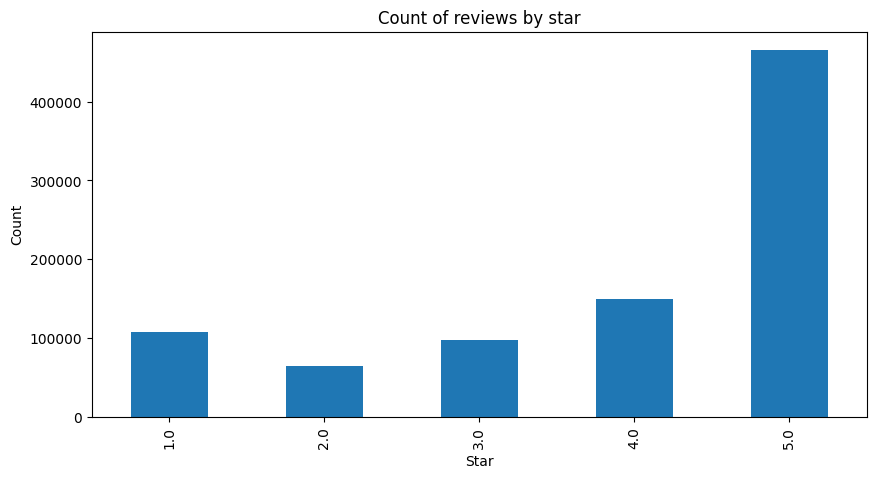

In [153]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")

notamos que los reviews estan sesgados hacia 5 estrellas

### Tokenizacion de comentarios

In [154]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\arase\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## MODULO 2
### Rating Score
calculamos el overall mean

In [155]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


agregamos la columnas id al dataframe df_meta

In [156]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos la muestra para facilitar el procesamiento 

In [157]:
CANTIDAD = 10000

In [158]:
df_meta_cortado = df_meta.head(CANTIDAD)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [159]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta_cortado.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_meta_cortadoFrame 'df_meta_cortado'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


C:\Users\arase\AppData\Local\Temp\ipykernel_8648\1163952785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_cortado.loc[:, 'combined_text'] = df_meta_cortado[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)


La matriz vecs contiene las puntuaciones TF-IDF ( Frecuencia de Término - Frecuencia Inversa de Documento) para cada palabra en cada documento. Las puntuaciones TF-IDF representan la importancia de una palabra para un documento en la colección.

In [160]:

vec = TfidfVectorizer()
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(10000, 22929)

## Modulo 3
### Similarity Score

Esto significa que tienes 10000 documentos (las filas del DataFrame df_meta_cortado) y 22929 palabras únicas en todos los documentos (las características).

calcular la similitud del coseno entre cada par de vectores en vecs

Su valor varía de -1 (vectores completamente opuestos) a 1 (vectores idénticos), con 0 indicando ortogonalidad (vectores perpendiculares).

In [161]:
similaridad = cosine_similarity(vecs)
similaridad

array([[1.        , 0.00388052, 0.039671  , ..., 0.00938346, 0.00938346,
        0.00179705],
       [0.00388052, 1.        , 0.        , ..., 0.        , 0.        ,
        0.00467325],
       [0.039671  , 0.        , 1.        , ..., 0.1177269 , 0.1177269 ,
        0.        ],
       ...,
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00938346, 0.        , 0.1177269 , ..., 1.        , 1.        ,
        0.        ],
       [0.00179705, 0.00467325, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [162]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(similaridad[item_id]))
    sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
    # si score es mayor o igual a 1 entonces se elimina de la lista
    scores_no_1 = [i for i in sorted_scores if i[1]<0.8]
    # fuzzificar el score
    # scores_no_1 = [(score[0], fuzzificar(scores_no_1[0][1], scores_no_1[-1][1], score[1])) for score in scores_no_1]
    # sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in scores_no_1]
    return (items_selected, scores_no_1)

### Seleccionamos 4 productos aleatorios

In [163]:
# Inicializa listas vacías para almacenar los resultados
asins_resultados = []
similaridad_score_resultados = []
random_asin_valores= []

# Lista de asins únicos del DataFrame df_meta_cortado
asins_unicos = df_meta_cortado['asin'].unique()

# Realiza 4 recomendaciones con valores aleatorios
for i in range(4):
    random_asin = random.choice(asins_unicos)
    print(random_asin)
    asins, similaridad_score = recommend(random_asin)
    # Agrega los resultados a las listas
    asins_resultados.append(asins)
    similaridad_score_resultados.append(similaridad_score)
    random_asin_valores.append(random_asin)


B0020MC8P6
B002TEEI58
B0004HD8VW
B004QYZEZ2


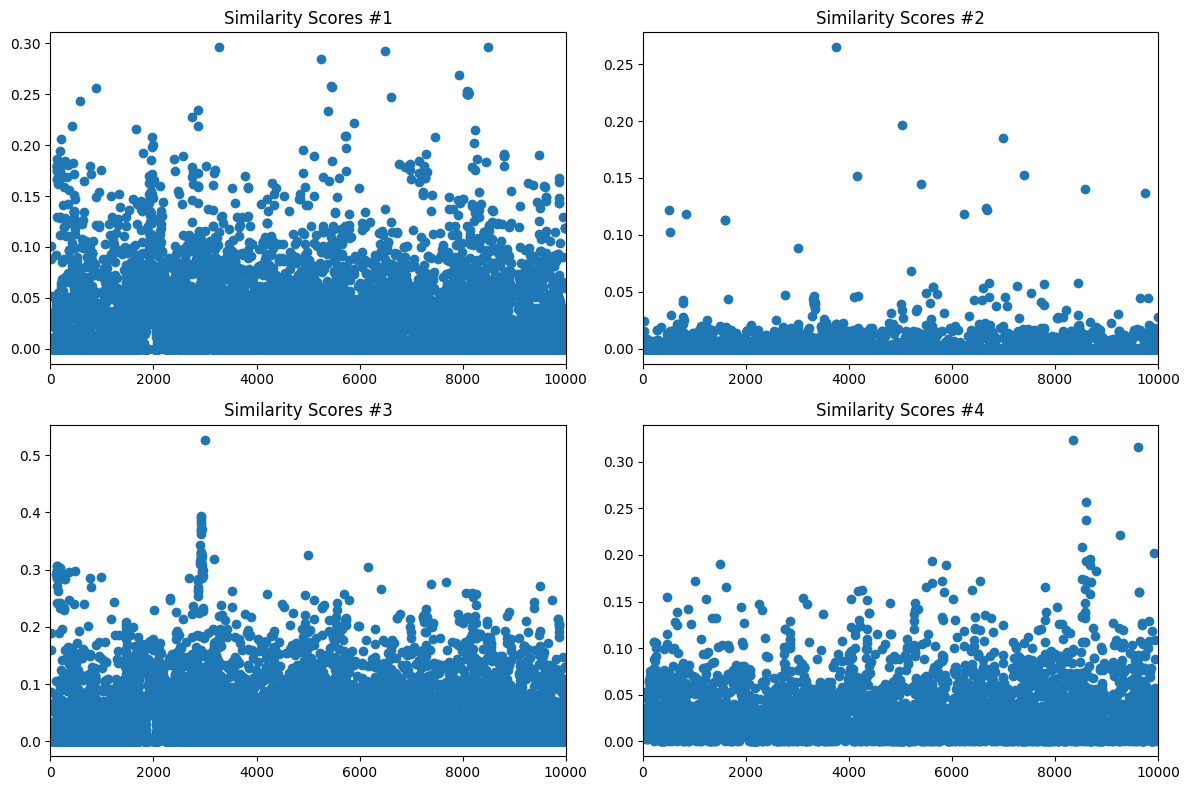

In [164]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Iterar a través de los 4 resultados y graficarlos en subplots separados
for i in range(4):
    scores_df = pd.DataFrame(similaridad_score_resultados[i], columns=['ItemID', 'Score'])
    ax = axs[i // 2, i % 2]  # Seleccionar el subplot adecuado
    ax.scatter(scores_df['ItemID'], scores_df['Score'])
    ax.set_title(f'Similarity Scores #{i+1}')
    ax.set_xlim(0, 10000)

plt.tight_layout()
plt.show()


In [165]:
# Inicializa listas vacías para almacenar los resultados
final_results = []
# Itera a través de los 4 conjuntos de resultados
for producto in range(4):
    top_scores_product = [similarity_score[1] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_item_ids_product = [similarity_score[0] for similarity_score in similaridad_score_resultados[producto][:CANTIDAD]]
    top_asin_product = asins_resultados[producto][:CANTIDAD]

    # Crear una lista de tuplas que contenga el ASIN, el score y el overall en el mismo orden
    data = list(zip(top_asin_product, top_scores_product, top_item_ids_product))

    # Crear un DataFrame a partir de los datos combinados
    df_result = pd.DataFrame(data, columns=['asin', 'Score', 'Id'])

    # Realizar un join entre df_result y result usando la columna 'ASIN' como clave de unión
    final_result = pd.merge(df_result, overall_mean, on='asin')
    print(final_result)
    final_results.append(final_result)



            asin     Score    Id   overall
0     B004M4VQAS  0.295989  8503  4.284133
1     B000UTJ99E  0.295959  3278  5.000000
2     B00311JTVQ  0.292248  6490  5.000000
3     B001TEIH7O  0.284232  5261  5.000000
4     B004BVH35E  0.268887  7928  4.000000
...          ...       ...   ...       ...
9994  B0058Z8MJS  0.000000  9989  5.000000
9995  B00590S7D8  0.000000  9990  5.000000
9996  B00591E4MK  0.000000  9992  4.777778
9997  B00591PC62  0.000000  9994  3.800000
9998  B00592SB5A  0.000000  9999  3.000000

[9999 rows x 4 columns]
            asin     Score    Id   overall
0     B0012QOGS8  0.264694  3748  2.000000
1     B001MWYDL2  0.196269  5030  3.000000
2     B003ITNRIW  0.185281  6988  1.000000
3     B003X26U3S  0.152757  7399  4.666667
4     B001869SXK  0.151529  4150  4.000000
...          ...       ...   ...       ...
9994  B00591PC62  0.000000  9994  3.800000
9995  B00591YLEG  0.000000  9995  5.000000
9996  B00591XGD8  0.000000  9996  5.000000
9997  B00591VVDA  0.000000  9

## MODULO 4
### Sistema de inferencia difuso

In [166]:
# Definimos las variables de entrada y salida para el sistema de control difuso
overall = ctrl.Antecedent(np.arange(1, 6, 0.1), 'overall')  # Calificación general
similaridad = ctrl.Antecedent(np.arange(-1, 1, 0.1), 'similaridad')  # Similaridad con otros elementos
recomendacion = ctrl.Consequent(np.arange(0, 2, 0.1), 'recomendacion')  # Recomendación resultante

# Definimos los trapecios para las variables de entrada y salida
overall['excelente'] = fuzz.trapmf(overall.universe, [4.1, 5, 5, 5]) # si el valor es [4.1 o 5], entonces es excelente
overall['bueno'] = fuzz.trapmf(overall.universe, [3.1, 4, 4, 4.1]) # si el valor es [3.1 o 4.1), entonces es bueno
overall['normal'] = fuzz.trapmf(overall.universe, [2.1, 3, 3, 3.1]) # si el valor es [2.1 o 3.1), entonces es normal
overall['pesimo'] = fuzz.trapmf(overall.universe, [0.99, 2, 2, 2.1]) # si el valor es (0.99 o 2.1), entonces es pesimo

similaridad['muy_similar'] = fuzz.trapmf(similaridad.universe, [0.7, 1, 1, 1]) # si el valor es [0.7 o 1], entonces es muy similar
similaridad['similar'] = fuzz.trapmf(similaridad.universe, [0.4, 0.7, 0.7, 0.7]) # si el valor es [0.4 o 0.7), entonces es similar
similaridad['poco_similar'] = fuzz.trapmf(similaridad.universe, [0.2, 0.4, 0.4, 0.4]) # si el valor es [0.2 o 0.4), entonces es poco similar
similaridad['no_similar'] = fuzz.trapmf(similaridad.universe, [-1, 0, 0, 0.2])  # si el valor es [-1 o 0.2), entonces es no similar


recomendacion['muy_recomendado'] = fuzz.trapmf(recomendacion.universe, [1.1, 2, 2, 2]) # si el valor es [1.1 o 2], entonces es muy recomendado
recomendacion['recomendado'] = fuzz.trapmf(recomendacion.universe, [0.1, 1, 1, 1.1]) # si el valor es [0.1 o 1.1), entonces es recomendado
recomendacion['no_recomendado'] = fuzz.trapmf(recomendacion.universe, [0, 0, 0, 0.1]) # si el valor es [0 o 0.1), entonces es no recomendado

# regla 1: si la similaridad es no similar y el overall es excelente, bueno, normal o pesimo, entonces la recomendacion es no recomendado
rule1 = ctrl.Rule(similaridad['no_similar'] & (overall['excelente'] | overall['bueno'] | overall['normal'] | overall['pesimo']), recomendacion['no_recomendado'])
# regla 2: si la similaridad es muy similar, similar, poco similar o no similar y el overall es pesimo, entonces la recomendacion es no recomendado
rule2 = ctrl.Rule(overall['pesimo'] & (similaridad['muy_similar'] | similaridad['similar'] | similaridad['poco_similar'] | similaridad['no_similar']), recomendacion['no_recomendado'])
# regla 3: si la similaridad es muy similar o similar y el overall es excelente o bueno, entonces la recomendacion es muy recomendado
rule3 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['muy_recomendado'])
# regla 4: si la similaridad es muy similar o similar y el overall es normal, entonces la recomendacion es recomendado
rule4 = ctrl.Rule(overall['normal']  & (similaridad['muy_similar'] | similaridad['similar']), recomendacion['recomendado'])
# regla 5: si la similaridad es muy similar o similar y el overall es excelente o bueno y poco similar, entonces la recomendacion es recomendado
rule5 = ctrl.Rule((overall['excelente'] | overall['bueno']) & (similaridad['poco_similar']), recomendacion['recomendado'])
# regla 6: si la similaridad es poco similar y el overall es normal, entonces la recomendacion es no recomendado
rule6 = ctrl.Rule(overall['normal'] & similaridad['poco_similar'], recomendacion['no_recomendado'])

# Sistema de control y simulación
sistema_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sistema_simulacion = ctrl.ControlSystemSimulation(sistema_control)

testeamos

In [167]:
# Pasar entradas al sistema
sistema_simulacion.input['overall'] = 4  # Ejemplo de calificación
sistema_simulacion.input['similaridad'] = 0.7  # Ejemplo de calificación
sistema_simulacion.compute() # Defuzzificación

# Por el metodo 'centroide'
print(sistema_simulacion.output['recomendacion'])

1.6333333333333335


## MODULO 5
### Defusificador

Defuzzificamos el resultado

In [168]:
def sistema_recomendacion_defuzzificado (recomendacion):
    if recomendacion < 0.1:
        return 'no_recomendado'
    elif recomendacion < 1.1:
        return 'recomendado'
    else:
        return 'muy_recomendado'
    

In [169]:
def sistema_recomendacion( similarity, overall):
    sistema_simulacion.input['overall'] = overall  # Ejemplo de calificación
    sistema_simulacion.input['similaridad'] = similarity # Ejemplo de calificación
    sistema_simulacion.compute() # Defuzzificación
    return (sistema_recomendacion_defuzzificado(sistema_simulacion.output['recomendacion']),sistema_simulacion.output['recomendacion'] )

In [170]:
# Itera a través de los 4 conjuntos de resultados

for i in range(4):
   # Aplicar la función fuzzyReglas a cada fila y crear una nueva columna 'result'
    final_results[i]['result'] = final_results[i].apply(lambda row: sistema_recomendacion(row['Score'], row['overall']), axis=1) 

# Para mostrar el DataFrame resultante
for i, df_result in enumerate(final_results):
    print(f"Resultados para conjunto {i + 1}: con asin ", random_asin_valores[i])
    sorted_results = final_results[i].sort_values(by='result', key=lambda x: x.apply(lambda y: y[1] if isinstance(y, tuple) else y), ascending=False)
    print(sorted_results['result'])
    print()



Resultados para conjunto 1: con asin  B0020MC8P6
4           (recomendado, 0.6641098544141159)
6           (recomendado, 0.6542926974258121)
10          (recomendado, 0.6495735734084094)
11          (recomendado, 0.6494370881220668)
12          (recomendado, 0.6489216576954908)
                        ...                  
8672    (no_recomendado, 0.03333333333333333)
6503    (no_recomendado, 0.03333333333333333)
6504    (no_recomendado, 0.03333333333333333)
6506    (no_recomendado, 0.03333333333333333)
9998    (no_recomendado, 0.03333333333333333)
Name: result, Length: 9999, dtype: object

Resultados para conjunto 2: con asin  B002TEEI58
2832    (no_recomendado, 0.049999999999999115)
9763    (no_recomendado, 0.049999999999999115)
3719    (no_recomendado, 0.049999999999999115)
5945    (no_recomendado, 0.049999999999999115)
1352    (no_recomendado, 0.049999999999999115)
                         ...                  
7497     (no_recomendado, 0.03333333333333333)
3357     (no_recomendado

In [173]:
for i in range(4):
    producto_encontrado = df_meta_cortado.loc[df_meta_cortado['asin'] == random_asin_valores[i]] 
    print("Para el producto: ") 
    producto_encontrado
    resultado_completo = pd.merge(final_results[i], df_meta_cortado, on='asin')
    resultado_completo


Para el producto: 
Para el producto: 


Para el producto: 
Para el producto: 
